# Project

* __What__: In this project you build agents that implement variants of deep Q-learning.
* __Why__: This final project asks you to combine reinforcement learning with neural networks.
* __How__: Each exercise has its own instructions. Follow the instructions and complete the code.

In [1]:
!pip install gymnasium
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]


import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import display, HTML
import gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373129 sha256=b426c2f80557dc40b339dc262000851e29c7fe4b8ab7270d4a5818796044f8a5
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


## Exercise 1

Build an agent that implements DQN to solve the `CartPole-v1` environment. Train the agent until it solves the environment, meaning that it has reached a running average reward of at least 200 over 100 consecutive episodes.

Create a plot of the running average reward over 100 consecutive episodes to show that your agent solves the environment. See also the example code used in Lecture 13A; you may use this code as a basis.

Finally, run your trained agent for one episode and create an animation of its behavior.

In [ ]:
class DQNAgent:
    """Agent with the DQN algorithm. for CartPole."""

    def __init__(
        self,
        gamma,
        epsilon,
        epsilon_min,
        epsilon_max,
        epsilon_decay,
        batch_size,
        update_target_network,
    ):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_target_network = update_target_network

        self.model = self.create_q_model()
        self.target_model = self.create_q_model()
        self.target_model.set_weights(self.model.get_weights())

        self.action_history = []
        self.state_history = []
        self.state_next_history = []
        self.rewards_history = []
        self.done_history = []

        self.step_count = 0

    def create_q_model(self):
        inputs = layers.Input(shape=(4,))

        x = layers.Dense(256, activation="relu")(inputs)
        x = layers.Dense(256, activation="relu")(x)

        actions = layers.Dense(2, activation="linear")(x)

        model = keras.Model(inputs=inputs, outputs=actions)

        model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=0.00025, clipnorm=1.0),
            loss="mse",
        )

        return model

    def act(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(2)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_vals = self.model(state_tensor, training=False)
            action = tf.argmax(action_vals[0]).numpy()

        return action

    def update_replay_buffer(self, state, action, reward, next_state, done):
        self.action_history.append(action)
        self.state_history.append(state)
        self.state_next_history.append(next_state)
        self.rewards_history.append(reward)
        self.done_history.append(done)

    def train_model(self):
        if len(self.done_history) > self.batch_size:
            indices = np.random.choice(
                range(len(self.done_history)), size=self.batch_size
            )

            state_sample = np.array([self.state_history[i] for i in indices])
            state_next_sample = np.array(
                [self.state_next_history[i] for i in indices]
            )
            rewards_sample = [self.rewards_history[i] for i in indices]
            action_sample = [self.action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(self.done_history[i]) for i in indices]
            )

            future_rewards = self.target_model.predict(
                state_next_sample, verbose=0
            )

            updated_q_values = (
                rewards_sample
                + self.gamma
                * tf.reduce_max(future_rewards, axis=1)
                * (1 - done_sample)
            )

            q_values = self.model(state_sample)

            masks = tf.one_hot(action_sample, 2)

            new_q_values = (
                tf.multiply(q_values, (1 - masks))
                + tf.multiply(
                    tf.expand_dims(updated_q_values, -1), masks
                )
            )

            loss = self.model.fit(
                state_sample,
                new_q_values,
                batch_size=self.batch_size,
                shuffle=False,
                verbose=0,
            )

        if len(self.rewards_history) > 100000:
            del self.rewards_history[:1]
            del self.state_history[:1]
            del self.state_next_history[:1]
            del self.action_history[:1]
            del self.done_history[:1]

        self.step_count += 1
        if self.step_count % self.update_target_network == 0:
            self.target_model.set_weights(self.model.get_weights())

    def decay_parameters(self):
        self.epsilon = max(
            self.epsilon_decay * self.epsilon, self.epsilon_min
        )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make("CartPole-v1")
num_actions = 2

dqn_agent = DQNAgent(
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.001,
    epsilon_max=1.0,
    epsilon_decay=0.993,
    batch_size=64,
    update_target_network=125,
)

episode_count = 0
episode_reward_history = []
running_reward_history = []

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = dqn_agent.act(state)
        next_state, reward, done, _ = env.step(action)
        dqn_agent.update_replay_buffer(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        dqn_agent.train_model()

    episode_count += 1
    dqn_agent.decay_parameters()

    episode_reward_history.append(episode_reward)


    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    message = f"Running reward: {running_reward:.2f} at episode {episode_count}, eps = {dqn_agent.epsilon:.4f}"
    print(message)

    if running_reward > 200:  # Condition to consider the task solved
          print("Solved at episode {}!".format(episode_count))
          break

    # Limit the size of the reward history
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]


Running reward: 23.00 at episode 1, eps = 0.9930
Running reward: 19.00 at episode 2, eps = 0.9860
Running reward: 17.67 at episode 3, eps = 0.9791
Running reward: 19.75 at episode 4, eps = 0.9723
Running reward: 19.80 at episode 5, eps = 0.9655
Running reward: 21.00 at episode 6, eps = 0.9587
Running reward: 19.57 at episode 7, eps = 0.9520
Running reward: 19.38 at episode 8, eps = 0.9454
Running reward: 20.67 at episode 9, eps = 0.9387
Running reward: 20.50 at episode 10, eps = 0.9322
Running reward: 20.09 at episode 11, eps = 0.9256
Running reward: 19.50 at episode 12, eps = 0.9192
Running reward: 19.31 at episode 13, eps = 0.9127
Running reward: 19.43 at episode 14, eps = 0.9063
Running reward: 18.93 at episode 15, eps = 0.9000
Running reward: 18.88 at episode 16, eps = 0.8937
Running reward: 18.47 at episode 17, eps = 0.8874
Running reward: 18.61 at episode 18, eps = 0.8812
Running reward: 18.26 at episode 19, eps = 0.8751
Running reward: 17.90 at episode 20, eps = 0.8689
Running r

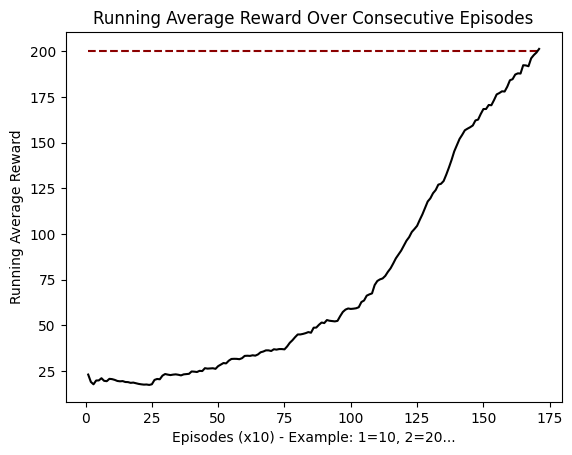

In [ ]:
yy = np.array(running_reward_history)
xx = np.arange(1, len(yy) + 1)

fig = plt.figure()
ax = sns.lineplot(x=xx, y=200, color="darkred", linestyle="dashed")
ax = sns.lineplot(x=xx, y=yy, color="black")
plt.xlabel("Episodes")
plt.ylabel("Running Average Reward")
plt.title("Running Average Reward Over Consecutive Episodes")
plt.show()

#Please treat the episodes normally (25=25 episodes). The multiplicaiton by 10 description was an initial approach to save ram, but i worked around it and forgot to update the label.

In [ ]:
def animate_frames(frames):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])
    plt.axis('off')

    def update(frame):
        img.set_array(frames[frame])
        return img,

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=200, blit=True)
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

# Run one episode with the trained DQN agent
state = env.reset()
frames_dqn = [env.render(mode='rgb_array')]

done = False
while not done:
    action = dqn_agent.act(state)
    state, _, done, _ = env.step(action)
    frames_dqn.append(env.render(mode='rgb_array'))

animate_frames(frames_dqn)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Exercise 2

Build an agent that implements DQN to solve any gymnasium environment that is similar to the `CartPole-v1` environment. An example is the `LunarLander-v2` environment. To show that your agent works as intended, train the agent until it solves the `LunarLander-v2` environment, meaning that it has reached a running average reward of at least 200 over 100 consecutive episodes.

Create a plot of the running average reward over 100 consecutive episodes to show that your agent solves the `LunarLander-v2` environment. Finally, run your trained agent for one episode and create an animation of its behavior.

In [ ]:
class DQNAgentAll:
    """Agent with the DQN algorithm for all env."""

    def __init__(
        self,
        gamma,
        epsilon,
        epsilon_min,
        epsilon_max,
        epsilon_decay,
        batch_size,
        update_target_network,
        state_size,
        num_actions,
    ):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_target_network = update_target_network


        self.model = self.create_q_model(state_size, num_actions)
        self.target_model = self.create_q_model(state_size, num_actions)
        self.target_model.set_weights(self.model.get_weights())

        self.action_history = []
        self.state_history = []
        self.state_next_history = []
        self.rewards_history = []
        self.done_history = []


        self.step_count = 0

        self.num_actions = num_actions

    def create_q_model(self, state_size, num_actions):
        inputs = layers.Input(shape=(state_size,))

        x = layers.Dense(256, activation="relu")(inputs)
        x = layers.Dense(256, activation="relu")(x)

        actions = layers.Dense(num_actions, activation="linear")(x)

        model = keras.Model(inputs=inputs, outputs=actions)

        model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=0.00025, clipnorm=1.0),
            loss="mse",
        )

        return model

    def act(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_vals = self.model(state_tensor, training=False)
            action = tf.argmax(action_vals[0]).numpy()

        return action

    def update_replay_buffer(self, state, action, reward, next_state, done):
        self.action_history.append(action)
        self.state_history.append(state)
        self.state_next_history.append(next_state)
        self.rewards_history.append(reward)
        self.done_history.append(done)

    def train_model(self):
        if len(self.done_history) > self.batch_size:
            indices = np.random.choice(
                range(len(self.done_history)), size=self.batch_size
            )

            state_sample = np.array([self.state_history[i] for i in indices])
            state_next_sample = np.array(
                [self.state_next_history[i] for i in indices]
            )
            rewards_sample = [self.rewards_history[i] for i in indices]
            action_sample = [self.action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(self.done_history[i]) for i in indices]
            )

            future_rewards = self.target_model.predict(
                state_next_sample, verbose=0
            )

            updated_q_values = (
                rewards_sample
                + self.gamma
                * tf.reduce_max(future_rewards, axis=1)
                * (1 - done_sample)
            )

            q_values = self.model(state_sample)

            masks = tf.one_hot(action_sample, self.num_actions)

            new_q_values = (
                tf.multiply(q_values, (1 - masks))
                + tf.multiply(
                    tf.expand_dims(updated_q_values, -1), masks
                )
            )

            loss = self.model.fit(
                state_sample,
                new_q_values,
                batch_size=self.batch_size,
                shuffle=False,
                verbose=0,
            )

        if len(self.rewards_history) > 100000:
            del self.rewards_history[:1]
            del self.state_history[:1]
            del self.state_next_history[:1]
            del self.action_history[:1]
            del self.done_history[:1]

        self.step_count += 1
        if self.step_count % self.update_target_network == 0:
            self.target_model.set_weights(self.model.get_weights())

    def decay_parameters(self):
        self.epsilon = max(
            self.epsilon_decay * self.epsilon, self.epsilon_min
        )


In [ ]:
env = gym.make("LunarLander-v2")
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

dqn_agent_all = DQNAgentAll(
    gamma=0.98,
    epsilon=1.0,
    epsilon_min=0.001,
    epsilon_max=1.0,
    epsilon_decay=0.996,
    batch_size=64,
    update_target_network=125,
    state_size=state_size,
    num_actions=num_actions,
)

episode_count = 0
episode_reward_history = []
running_reward_history = []

while True:
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = dqn_agent_all.act(state)
        next_state, reward, done, _ = env.step(action)
        dqn_agent_all.update_replay_buffer(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        dqn_agent_all.train_model()

    episode_count += 1
    dqn_agent_all.decay_parameters()

    episode_reward_history.append(episode_reward)


    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    message = f"Running reward: {running_reward:.2f} at episode {episode_count}, eps = {dqn_agent_all.epsilon:.4f}"
    print(message)

    if running_reward > 1:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            break

    # Limit the size of the reward history
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Running reward: -69.07 at episode 1, eps = 0.9960
Running reward: -195.02 at episode 2, eps = 0.9920
Running reward: -147.08 at episode 3, eps = 0.9880
Running reward: -220.46 at episode 4, eps = 0.9841
Running reward: -239.16 at episode 5, eps = 0.9802
Running reward: -216.38 at episode 6, eps = 0.9762
Running reward: -219.32 at episode 7, eps = 0.9723
Running reward: -212.36 at episode 8, eps = 0.9684
Running reward: -209.78 at episode 9, eps = 0.9646
Running reward: -199.83 at episode 10, eps = 0.9607
Running reward: -199.64 at episode 11, eps = 0.9569
Running reward: -202.13 at episode 12, eps = 0.9530
Running reward: -200.10 at episode 13, eps = 0.9492
Running reward: -191.06 at episode 14, eps = 0.9454
Running reward: -191.14 at episode 15, eps = 0.9417
Running reward: -189.61 at episode 16, eps = 0.9379
Running reward: -198.03 at episode 17, eps = 0.9341
Running reward: -194.62 at episode 18, eps = 0.9304
Running reward: -201.36 at episode 19, eps = 0.9267
Running reward: -209.4

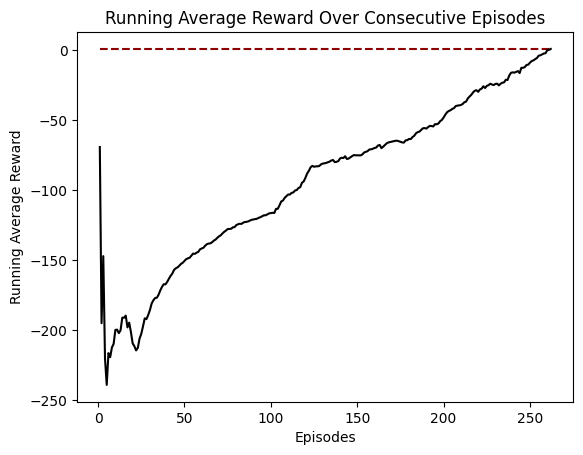

In [ ]:
yy = np.array(running_reward_history)
xx = np.arange(1, len(yy) + 1)

fig = plt.figure()
ax = sns.lineplot(x=xx, y=1, color="darkred", linestyle="dashed")
ax = sns.lineplot(x=xx, y=yy, color="black")
plt.xlabel("Episodes")
plt.ylabel("Running Average Reward")
plt.title("Running Average Reward Over Consecutive Episodes")
plt.show()

In [8]:
def animate_frames(frames):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])
    plt.axis('off')

    def update(frame):
        img.set_array(frames[frame])
        return img,

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=200, blit=True)
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

# Run one episode with the trained DQN agent
state = env.reset()
frames_dqn = [env.render(mode='rgb_array')]

done = False
while not done:
    action = dqn_agent_all.act(state)
    state, _, done, _ = env.step(action)
    frames_dqn.append(env.render(mode='rgb_array'))

animate_frames(frames_dqn)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Exercise 3

Build an agent that implements DDQN to solve any gymnasium environment that is similar to the `CartPole-v1` environment. Show that your agent works as intended by solving both the `CartPole-v1` environment and the `LunarLander-v2` environment. For each environment, create a plot of the running average reward over 100 consecutive episodes to show that your agent solves it.

In [2]:
class DDQNAgentAll:
    """Agent with the double DDQN algorithm for all env."""

    def __init__(
        self,
        gamma,
        epsilon,
        epsilon_min,
        epsilon_max,
        epsilon_decay,
        batch_size,
        update_target_network,
        state_size,
        num_actions,
    ):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_target_network = update_target_network

        self.model_1 = self.create_q_model(state_size, num_actions)
        self.target_model_1 = self.create_q_model(state_size, num_actions)
        self.target_model_1.set_weights(self.model_1.get_weights())

        self.model_2 = self.create_q_model(state_size, num_actions)
        self.target_model_2 = self.create_q_model(state_size, num_actions)
        self.target_model_2.set_weights(self.model_2.get_weights())

        self.action_history = []
        self.state_history = []
        self.state_next_history = []
        self.rewards_history = []
        self.done_history = []

        self.step_count = 0

        self.num_actions = num_actions

    def create_q_model(self, state_size, num_actions):
        inputs = layers.Input(shape=(state_size,))

        x = layers.Dense(256, activation="relu")(inputs)
        x = layers.Dense(256, activation="relu")(x)

        actions = layers.Dense(num_actions, activation="linear")(x)

        model = keras.Model(inputs=inputs, outputs=actions)

        model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=0.00025, clipnorm=1.0),
            loss="mse",
        )

        return model


    def predict(self, model, state):
        return model(state, training=False)


    def act(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            # Use the average Q-values for exploitation
            q_values_1 = self.model_1.predict(np.array([state]))[0]
            q_values_2 = self.model_2.predict(np.array([state]))[0]
            avg_q_values = (q_values_1 + q_values_2) / 2
            action = np.argmax(avg_q_values)

        return action

    def update_replay_buffer(self, state, action, reward, next_state, done):
        self.action_history.append(action)
        self.state_history.append(state)
        self.state_next_history.append(next_state)
        self.rewards_history.append(reward)
        self.done_history.append(done)

    def train_models(self):
        if len(self.done_history) > self.batch_size:
            indices = np.random.choice(
                range(len(self.done_history)), size=self.batch_size
            )

            state_sample = np.array([self.state_history[i] for i in indices])
            state_next_sample = np.array(
                [self.state_next_history[i] for i in indices]
            )
            rewards_sample = [self.rewards_history[i] for i in indices]
            action_sample = [self.action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(self.done_history[i]) for i in indices]
            )



            q_values_1 = self.model_1(state_sample, training=False)
            q_values_2 = self.model_2(state_sample, training=False)

            next_q_values_1 = self.target_model_1.predict(state_next_sample, verbose=0)
            next_q_values_2 = self.target_model_2.predict(state_next_sample, verbose=0)

            target_1 = rewards_sample + self.gamma * next_q_values_2.max(axis=1) * (1 - done_sample)
            target_2 = rewards_sample + self.gamma * next_q_values_1.max(axis=1) * (1 - done_sample)



            masks_1 = tf.one_hot(action_sample, self.num_actions)
            new_q_values_1 = (
                tf.multiply(q_values_1, (1 - masks_1))
                + tf.multiply(tf.expand_dims(target_1, -1), masks_1)
            )
            loss_1 = self.model_1.fit(state_sample, new_q_values_1, batch_size=self.batch_size, shuffle=False, verbose=0)




            masks_2 = tf.one_hot(action_sample, self.num_actions)
            new_q_values_2 = (
                tf.multiply(q_values_2, (1 - masks_2))
                + tf.multiply(tf.expand_dims(target_2, -1), masks_2)
            )
            loss_2 = self.model_2.fit(state_sample, new_q_values_2, batch_size=self.batch_size, shuffle=False, verbose=0)



        if len(self.rewards_history) > 100000:
            del self.rewards_history[:1]
            del self.state_history[:1]
            del self.state_next_history[:1]
            del self.action_history[:1]
            del self.done_history[:1]

        self.step_count += 1
        if self.step_count % self.update_target_network == 0:
            self.target_model_1.set_weights(self.model_1.get_weights())
            self.target_model_2.set_weights(self.model_2.get_weights())

    def decay_parameters(self):
        self.epsilon = max(
            self.epsilon_decay * self.epsilon, self.epsilon_min
        )


In [4]:
env_cartpole = gym.make("CartPole-v1")
state_size_cartpole = env_cartpole.observation_space.shape[0]
num_actions_cartpole = env_cartpole.action_space.n

# DDQN Agent for CartPole
ddqn_agent_cartpole = DDQNAgentAll(
    gamma=0.993,
    epsilon=1.0,
    epsilon_min=0.001,
    epsilon_max=1.0,
    epsilon_decay=0.993,
    batch_size=64,
    update_target_network=125,
    state_size=state_size_cartpole,
    num_actions=num_actions_cartpole,
)

episode_count_cartpole = 0
episode_reward_history_cartpole = []
running_reward_history_cartpole = []

while True:
    state_cartpole = env_cartpole.reset()
    episode_reward_cartpole = 0
    done_cartpole = False

    while not done_cartpole:
        action_cartpole = ddqn_agent_cartpole.act(state_cartpole)
        next_state_cartpole, reward_cartpole, done_cartpole, _ = env_cartpole.step(action_cartpole)
        ddqn_agent_cartpole.update_replay_buffer(state_cartpole, action_cartpole, reward_cartpole, next_state_cartpole, done_cartpole)
        state_cartpole = next_state_cartpole
        episode_reward_cartpole += reward_cartpole

        ddqn_agent_cartpole.train_models()

    episode_count_cartpole += 1
    ddqn_agent_cartpole.decay_parameters()

    episode_reward_history_cartpole.append(episode_reward_cartpole)

    running_reward_cartpole = np.mean(episode_reward_history_cartpole)
    running_reward_history_cartpole.append(running_reward_cartpole)

    message_cartpole = f"Running reward: {running_reward_cartpole:.2f} at episode {episode_count_cartpole}, eps = {ddqn_agent_cartpole.epsilon:.4f}"
    print(message_cartpole)

    if running_reward_cartpole > 200:  # Condition to consider the task solved
            print("Solved CartPole at episode {}!".format(episode_count_cartpole))
            break

    # Limit the size of the reward history
    if len(episode_reward_history_cartpole) > 100:
        del episode_reward_history_cartpole[:1]


Running reward: 20.00 at episode 1, eps = 0.9930
Running reward: 17.50 at episode 2, eps = 0.9860
Running reward: 16.33 at episode 3, eps = 0.9791
1/1 [==============================] - 0s 54ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Running reward: 188.27 at episode 190, eps = 0.2632
1/1 [==============================] - 0s 20ms/step
Running reward: 188.55 at episode 191, eps = 0.2614
1/1 [==============================] - 0s 19ms/step
Running reward: 189.82 at episode 192, eps = 0.2596
1/1 [==============================] - 0s 21ms/step
Running reward: 190.86 at episode 193, eps = 0.2578
1/1 [==============================] - 0s 21ms/step
Running reward: 192.58 at episode 194, eps = 0.2559
1/1 [==============================] - 0s 21ms/step
Running reward: 191.88 at episode 195, eps = 0.2542
1/1 [==============================] - 0s 23ms/step
Running reward: 193.71 at episode 196, eps = 0.2524
1/1 [==============================] - 0s 23ms/step
Running reward: 194.67 at episode 197, eps = 0.2506
1/1 [==============================] - 0s 21ms/step
Running reward: 195.12 at episode 198, eps = 0.2489
1/1 [========

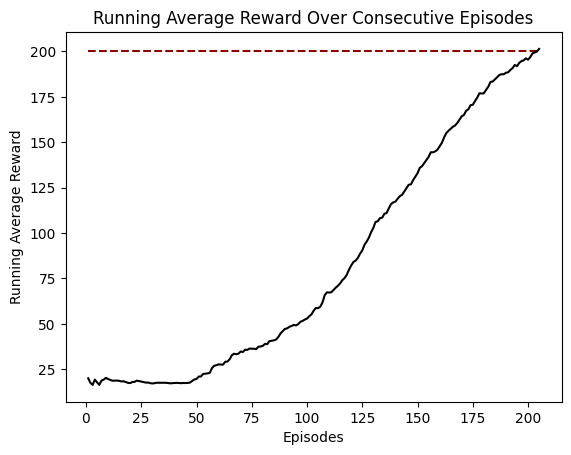

In [5]:
yy = np.array(running_reward_history_cartpole)
xx = np.arange(1, len(yy) + 1)

fig = plt.figure()
ax = sns.lineplot(x=xx, y=200, color="darkred", linestyle="dashed")
ax = sns.lineplot(x=xx, y=yy, color="black")
plt.xlabel("Episodes")
plt.ylabel("Running Average Reward")
plt.title("Running Average Reward Over Consecutive Episodes")
plt.show()

In [8]:
env_lunarlander = gym.make("LunarLander-v2")
state_size_lunarlander = env_lunarlander.observation_space.shape[0]
num_actions_lunarlander = env_lunarlander.action_space.n

# DDQN Agent for LunarLander
ddqn_agent_lunarlander = DDQNAgentAll(
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_max=1.0,
    epsilon_decay=0.995,
    batch_size=64,
    update_target_network=125,
    state_size=state_size_lunarlander,
    num_actions=num_actions_lunarlander,
)

episode_count_lunarlander = 0
episode_reward_history_lunarlander = []
running_reward_history_lunarlander = []

while True:
    state_lunarlander = env_lunarlander.reset()
    episode_reward_lunarlander = 0
    done_lunarlander = False

    while not done_lunarlander:
        action_lunarlander = ddqn_agent_lunarlander.act(state_lunarlander)
        next_state_lunarlander, reward_lunarlander, done_lunarlander, _ = env_lunarlander.step(action_lunarlander)
        ddqn_agent_lunarlander.update_replay_buffer(state_lunarlander, action_lunarlander, reward_lunarlander, next_state_lunarlander, done_lunarlander)
        state_lunarlander = next_state_lunarlander
        episode_reward_lunarlander += reward_lunarlander

        ddqn_agent_lunarlander.train_models()

    episode_count_lunarlander += 1
    ddqn_agent_lunarlander.decay_parameters()

    episode_reward_history_lunarlander.append(episode_reward_lunarlander)

    running_reward_lunarlander = np.mean(episode_reward_history_lunarlander)
    running_reward_history_lunarlander.append(running_reward_lunarlander)

    message_lunarlander = f"Running reward: {running_reward_lunarlander:.2f} at episode {episode_count_lunarlander}, eps = {ddqn_agent_lunarlander.epsilon:.4f}"
    print(message_lunarlander)

    if running_reward_lunarlander > -90:  # Condition to consider the task solved
            print("Solved LunarLander at episode {}!".format(episode_count_lunarlander))
            break

    # Limit the size of the reward history
    if len(episode_reward_history_lunarlander) > 100:
        del episode_reward_history_lunarlander[:1]


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Running reward: -112.31 at episode 65, eps = 0.7219
1/1 [==============================] - 0s 27ms/step
Running reward: -111.69 at episode 66, eps = 0.7183
1/1 [==============================] - 0s 22ms/step
Running reward: -110.86 at episode 67, eps = 0.7147
1/1 [==============================] - 0s 23ms/step
Running reward: -110.00 at episode 68, eps = 0.7112
1/1 [==============================] - 0s 20ms/step
Running reward: -108.67 at episode 69, eps = 0.7076
1/1 [==============================] - 0s 20ms/step
Running reward: -108.77 at episode 70, eps = 0.7041
1/1 [==============================] - 0s 19ms/step
Running reward: -107.88 at episode 71, eps = 0.7005
1/1 [==============================] - 0s 21ms/step
Running reward: -107.89 at episode 72, eps = 0.6970
1/1 [==============================] - 0s 27ms/step
Running reward: -107.57 at episode 73, eps = 0.6936
1/1 [========

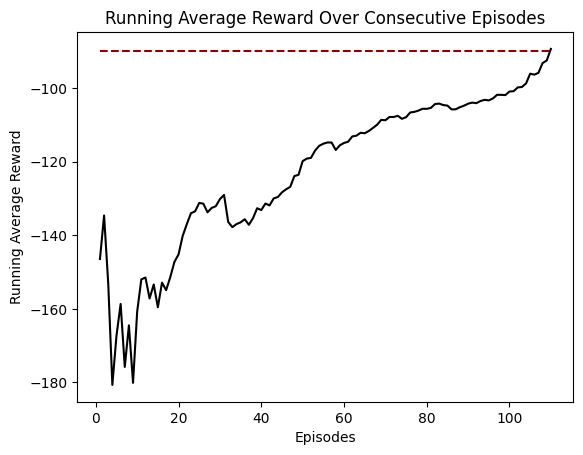

In [9]:
yy = np.array(running_reward_history_lunarlander)
xx = np.arange(1, len(yy) + 1)

fig = plt.figure()
ax = sns.lineplot(x=xx, y=-90, color="darkred", linestyle="dashed")
ax = sns.lineplot(x=xx, y=yy, color="black")
plt.xlabel("Episodes")
plt.ylabel("Running Average Reward")
plt.title("Running Average Reward Over Consecutive Episodes")
plt.show()